**Enhancing Image Classification Models with Regularization and Convolutional Layers**

The task involves **improving neural network performance** for **image classification** by applying **regularization technique** and **adding additional convolutional layers** to existing models. The goal is to **evaluate the impact** of these modifications on model performance, particularly in **preventing overfitting**. Techniques like **Dropout** are used for better generalization. The updated models are tested on **validation and test datasets** to assess improvements in **accuracy** and **classification results**
.

🔍 **More details and comments are available at the end of the file.**

**#0 Imports**

In [ ]:
# System modules
import os
import shutil
import random
import zipfile

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError

# Data processing and ML models
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Keras - neural network modeling
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Image processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**#1 Downloading and extracting the dataset**

In [ ]:
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2025-02-21 14:45:30--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.220.113.200, 2a02:26f0:6d00:3b6::317f, 2a02:26f0:6d00:39f::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.220.113.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   217MB/s    in 3.7s    

2025-02-21 14:45:34 (215 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



**#2 Deleting damaged photos**

In [ ]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

**#3 Defining directories and classifications**

In [ ]:
classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)

random.seed(101)
random.shuffle(original_cat)
random.shuffle(original_dog)

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


**#4 Splitting data into training, validation, and test sets**

In [ ]:
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'

**#5 Copying files to appropriate folders**

In [ ]:
index = 0
for name_cat, name_dog in zip(original_cat, original_dog):
    if index <= train_size:
        type_of_dataset = 'train'
    elif train_size < index <= (train_size + valid_size):
        type_of_dataset = 'valid'
    elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
        type_of_dataset = 'test'

    shutil.copyfile(src=(original_cat_path + '/' + name_cat), dst=(directories[f'{type_of_dataset}_Cat'] + name_cat))
    shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog'] + name_dog))
    index += 1

**#6 Preview the number of images in each collection**

In [ ]:
print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


**#7 Visualization of several images**

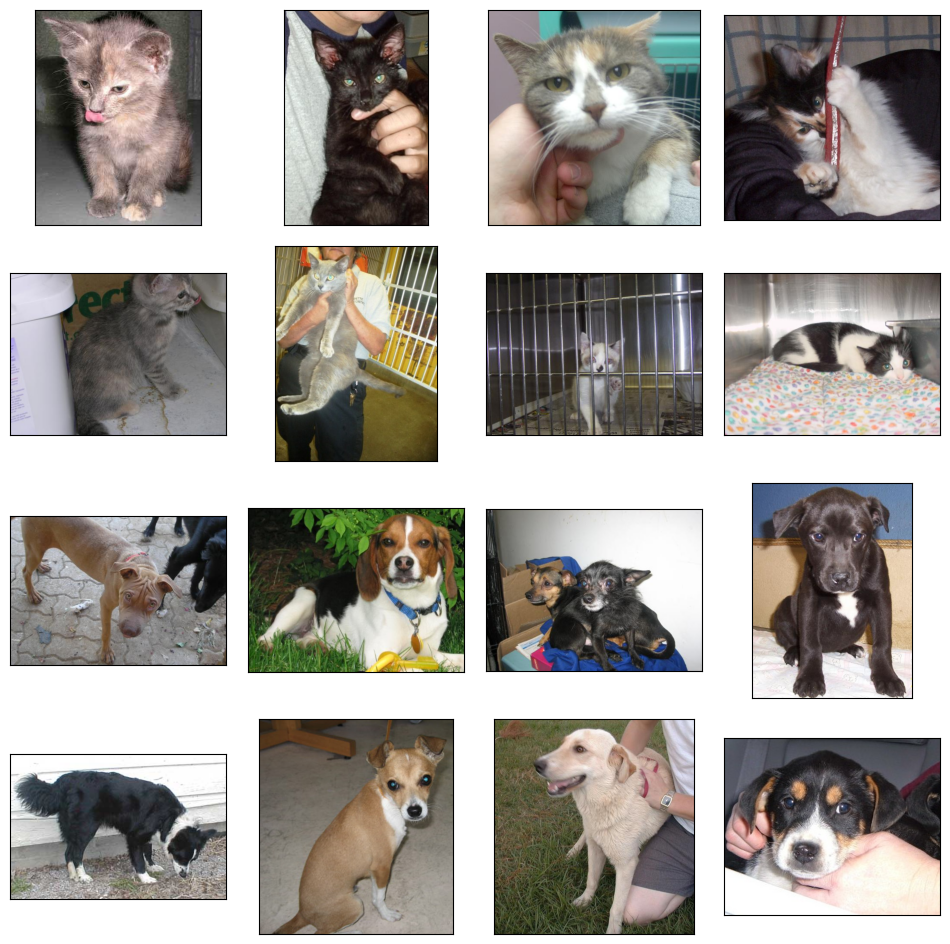

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Displaying cats
for i, element in enumerate(os.listdir(os.path.join(directories["train_Cat"]))[:8]):
    ax = fig.add_subplot(4, 4, i+1)
    img = Image.open(directories["train_Cat"] + element)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

# Displaying dogs
for i, element in enumerate(os.listdir(os.path.join(directories["train_Dog"]))[:8]):
    ax = fig.add_subplot(4, 4, i+9)
    img = Image.open(directories["train_Dog"] + element)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

**#8  Preparation of data generators**

In [ ]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
test_data_dir = 'dataset/test/'
epochs = 1000
batch_size = 64
validation_steps = valid_size // batch_size

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=batch_size,
                                                  class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


**#9 Data augmentation**

In [ ]:
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                                shear_range=0.2,
                                                zoom_range=0.2,
                                                rotation_range=30,
                                                horizontal_flip=True)

train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                                              target_size=(img_height, img_width),
                                                                              batch_size=batch_size,
                                                                              class_mode='binary')

Found 17500 images belonging to 2 classes.


**#10 Create folders for history and charts**

In [ ]:
models = []
os.mkdir("history")
os.mkdir("charts")

**#11 Baseline**

In [ ]:
model_baseline = Sequential()
model_baseline.add(Flatten(input_shape=(150, 150, 3)))  # Converting an image into a vector
model_baseline.add(Dense(units=1, activation='sigmoid'))  # Output layer
model_baseline.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])

model_baseline.summary()
models.append("baseline")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          67,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,501 (263.68 KB)

 Trainable params: 67,501 (263.68 KB)

 Non-trainable params: 0 (0.00 B)

**#12 Training the baseline model**

In [ ]:
es1 = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history_baseline = model_baseline.fit(train_generator,
                                      epochs=8,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[es1])

history_baseline_df = pd.DataFrame(history_baseline.history)
history_baseline_csv_file = 'history/history_baseline.csv'

# Save training history to CSV file
with open(history_baseline_csv_file, mode='w') as f:
    history_baseline_df.to_csv(f)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - accuracy: 0.5037 - loss: 1.0366 - val_accuracy: 0.5116 - val_loss: 0.7772
Epoch 2/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.5309 - loss: 0.8899 - val_accuracy: 0.5657 - val_loss: 0.6939
Epoch 3/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.5206 - loss: 0.9234 - val_accuracy: 0.5068 - val_loss: 1.2790
Epoch 4/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.5259 - loss: 0.9421 - val_accuracy: 0.4932 - val_loss: 1.1238
Epoch 5/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.5330 - loss: 0.9049 - val_accuracy: 0.5060 - val_loss: 1.1237
Epoch 6/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 42s 152ms/step - accuracy: 0.5459 - loss: 0.8960 - val_accuracy: 0.5136 - val_loss: 1.0992
Epoch 7/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/step - accuracy: 0.5395 - loss: 0.8894 - val_accuracy: 0.4984 - val_loss: 1.0165


**#13 Individual charting function for each model**

In [ ]:
def plot_individual_model_histories(models):
    max_index = 0
    min_accuracy = 1
    max_loss = 0

    # Loop processing data for each model
    for model in models:
        df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
        df.index += 1
        if max_index < max(df.index):
            max_index = max(df.index)
        if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
            min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
        if max_loss < max(df[['loss', 'val_loss']].max()):
            max_loss = max(df[['loss', 'val_loss']].max())

        # Accuracy plot for this model
        fig = plt.figure(figsize=(16, 12))
        ax = fig.add_subplot(211)
        ax.plot(df['accuracy'], "bp--")
        ax.plot(df['val_accuracy'], "rp--")
        ax.set_title(f'Model {model} Accuracy', fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([min_accuracy, 1])

        # Milestones
        for milestone in (0.7, 0.8, 0.9, 0.95):
            ax.axhline(milestone, color="k", linestyle="--")
            try:
                if min(df[df['val_accuracy'] >= milestone].index) > 1:
                    plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                    ax.text(min(df[df['val_accuracy'] >= milestone].index) + 0.6, min_accuracy + 0.02,
                            f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
            except:
                pass

        plt.legend(['Training', 'Validation'], loc='lower right')

        # Loss plot for this model
        ax = fig.add_subplot(212)
        ax.plot(df['loss'], "bp--")
        ax.plot(df['val_loss'], "rp--")
        ax.set_title(f'Model {model} Loss', fontsize=20)
        ax.set_ylabel('Loss', fontsize=15)
        ax.set_xlabel('Epoch', fontsize=15)
        ax.set_xlim([1, max_index])
        ax.set_ylim([0, max_loss])
        ax.legend(['Training', 'Validation'], loc='upper right')

        plt.tight_layout()
        plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
        plt.show()

**#14 Function to summarize results for all models**

In [ ]:
def plot_summary_histories(models):
    max_index = 0
    min_accuracy = 1
    max_loss = 0
    colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

    # Loop processing data from the history of all models
    for model in models:
        df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
        df.index += 1
        if max_index < max(df.index):
            max_index = max(df.index)
        if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
            min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
        if max_loss < max(df[['loss', 'val_loss']].max()):
            max_loss = max(df[['loss', 'val_loss']].max())

    # Summary Accuracy plot for all models
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(211)
    for model, color in zip(models, colors):
        df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
        df.index += 1
        ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
        ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

    ax.set_title(f'Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])
    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
    plt.legend(loc='lower right')

    # Summary Loss plot for all models
    ax = fig.add_subplot(212)
    for model, color in zip(models, colors):
        df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
        df.index += 1
        ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
        ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)

    ax.set_title(f'Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
    plt.show()

**#15 Visualization of the baseline model**

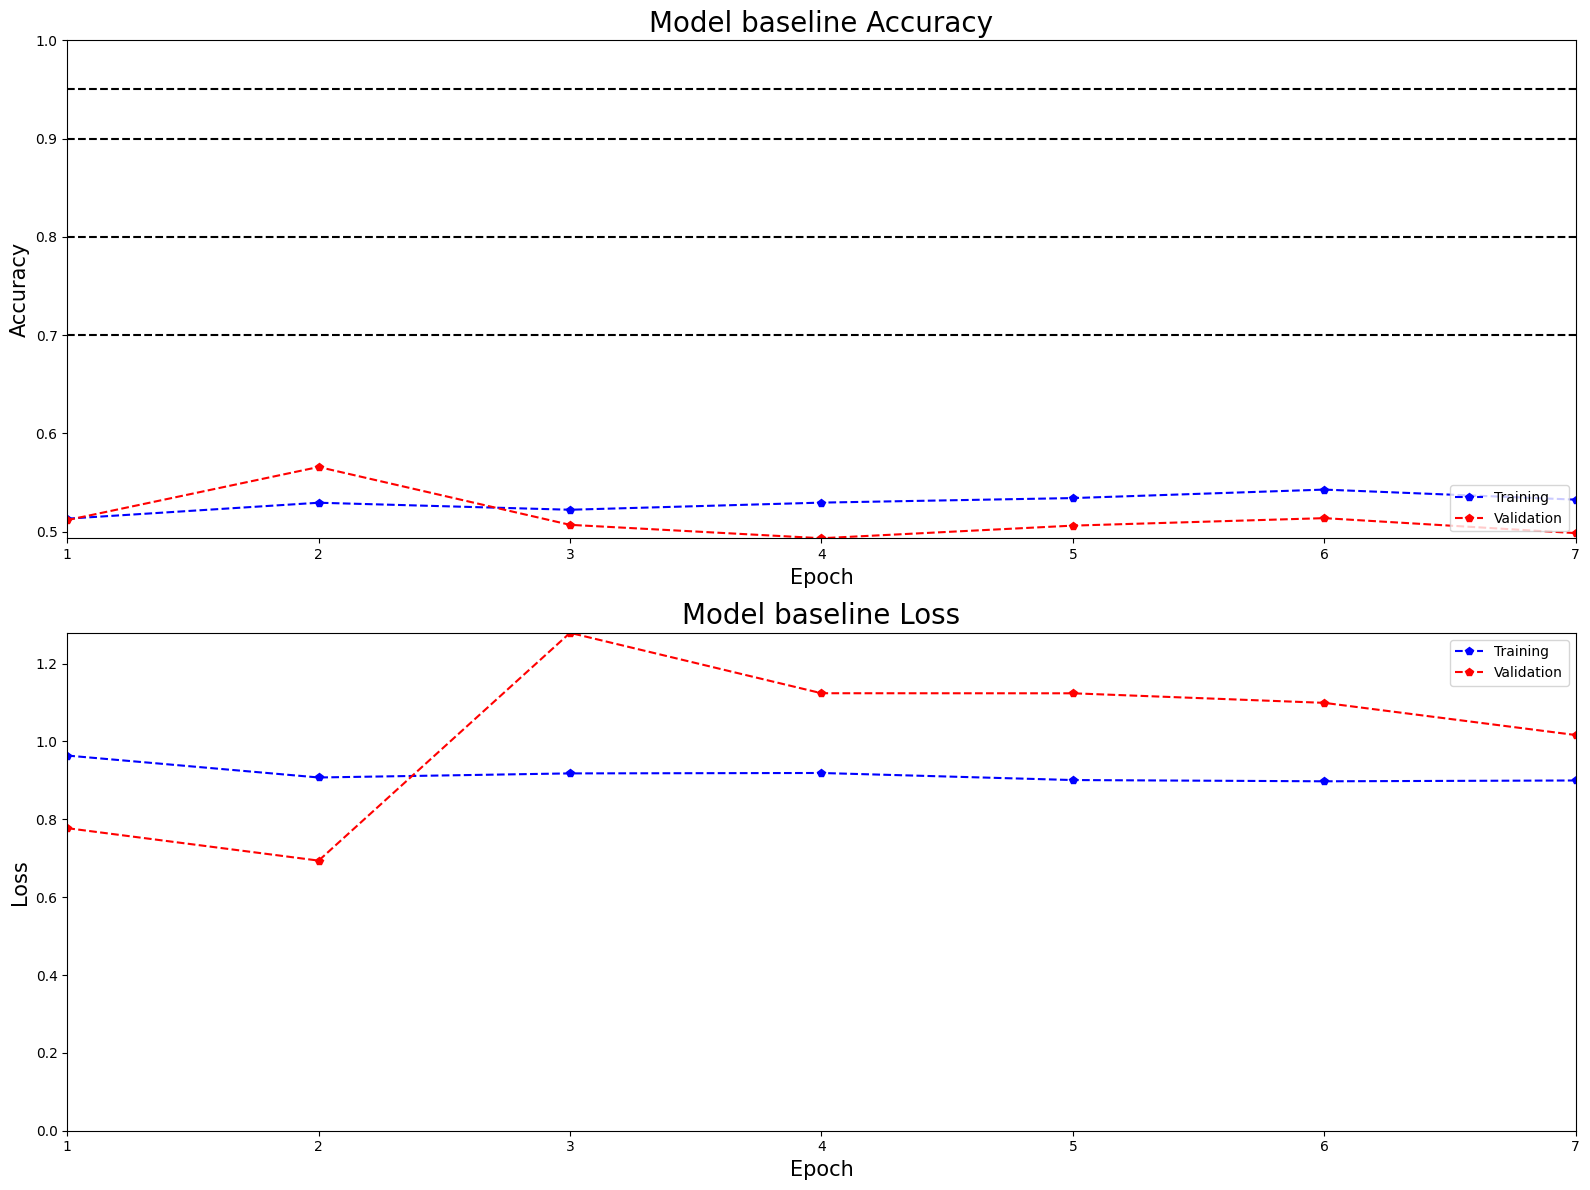

In [ ]:
plot_individual_model_histories(["baseline"])

**#16 Basic model 1**

In [ ]:
model_1 = Sequential()

# Block 1
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_1.summary()
models.append("model_1")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

**#17 Training the basic model 1**

In [ ]:
es2 = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history_model_1 = model_1.fit(train_generator,
                              epochs=8,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es2])

history_model_1_df = pd.DataFrame(history_model_1.history)
history_model_1_csv_file = 'history/history_model_1.csv'

with open(history_model_1_csv_file, mode='w') as f:
    history_model_1_df.to_csv(f)

Epoch 1/8
109/274 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - accuracy: 0.5131 - loss: 0.6924

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


274/274 ━━━━━━━━━━━━━━━━━━━━ 60s 182ms/step - accuracy: 0.5361 - loss: 0.6868 - val_accuracy: 0.6350 - val_loss: 0.6384
Epoch 2/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 63s 138ms/step - accuracy: 0.6495 - loss: 0.6179 - val_accuracy: 0.6819 - val_loss: 0.5841
Epoch 3/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.6968 - loss: 0.5709 - val_accuracy: 0.7280 - val_loss: 0.5208
Epoch 4/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - accuracy: 0.7235 - loss: 0.5370 - val_accuracy: 0.7428 - val_loss: 0.5142
Epoch 5/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - accuracy: 0.7517 - loss: 0.5047 - val_accuracy: 0.7740 - val_loss: 0.4869
Epoch 6/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - accuracy: 0.7669 - loss: 0.4834 - val_accuracy: 0.7712 - val_loss: 0.4767
Epoch 7/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 38s 139ms/step - accuracy: 0.7839 - loss: 0.4549 - val_accuracy: 0.8005 - val_loss: 0.4355
Epoch 8/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 41s 149ms/step - accuracy: 0.7989 - loss: 0.4287 - val_accura

**#18  Visualization of the basic model 1**

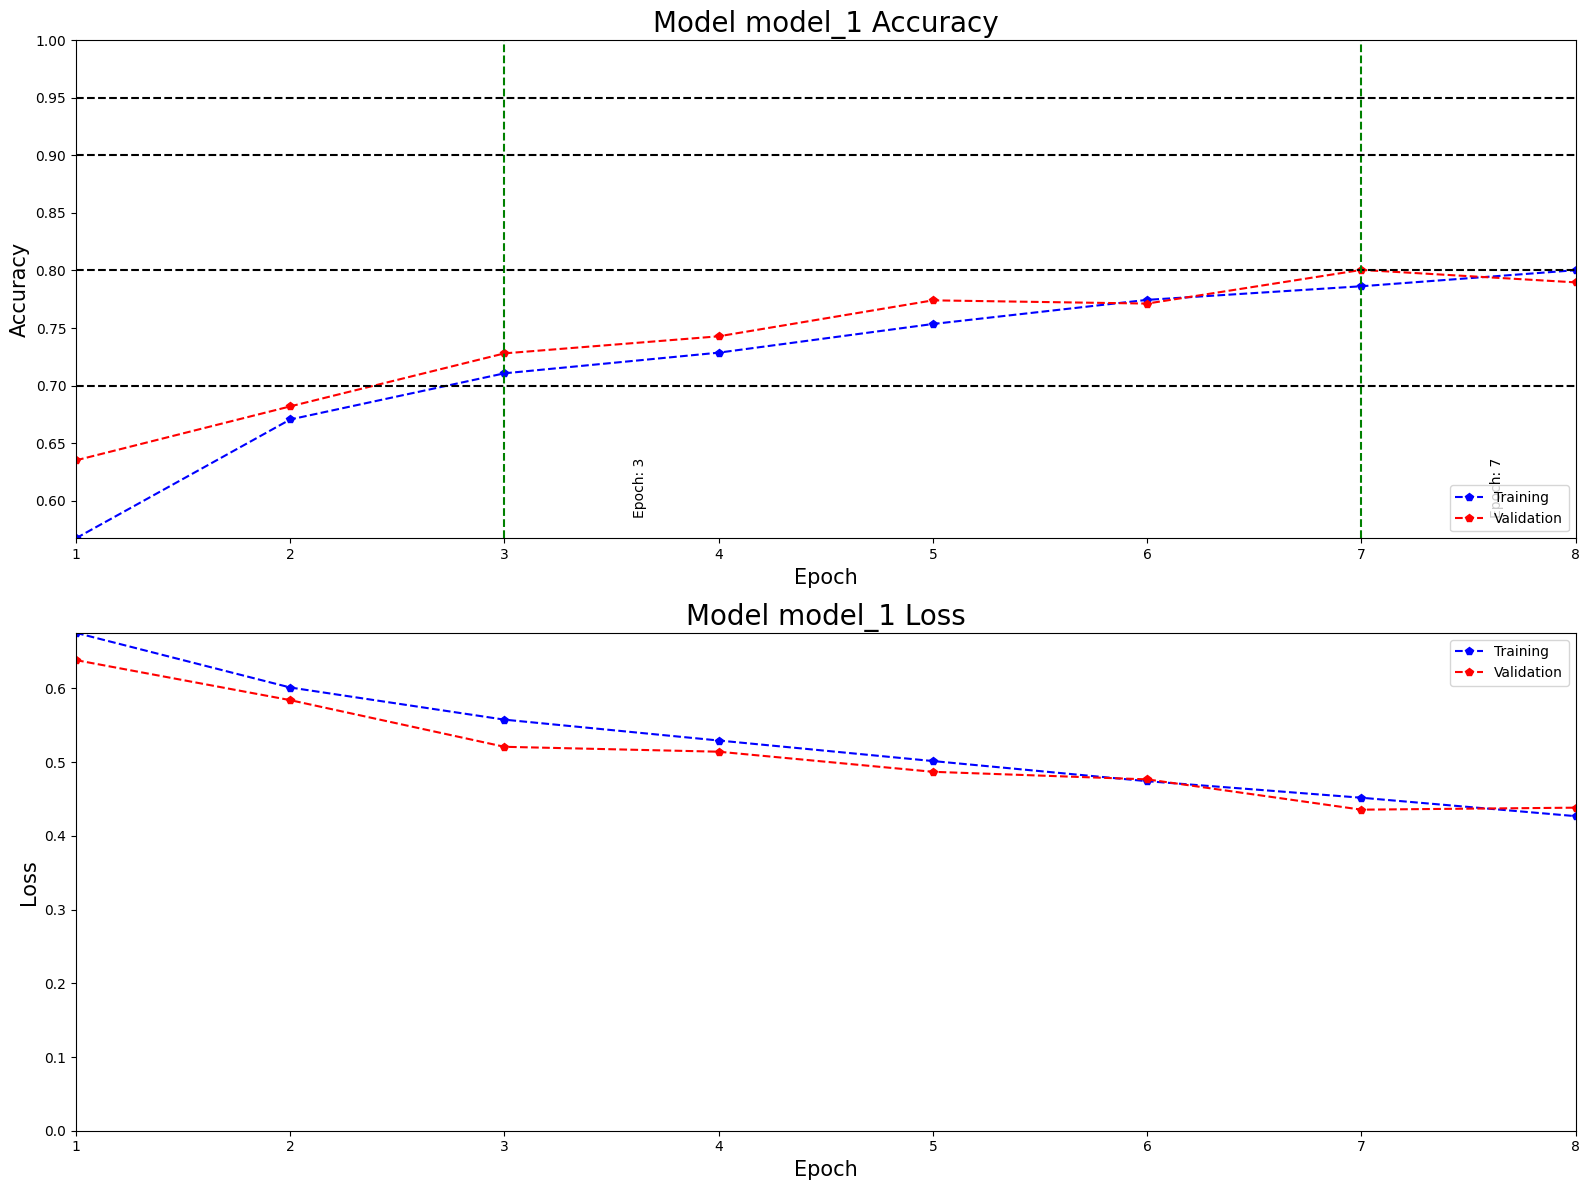

In [ ]:
plot_individual_model_histories(["model_1"])

**#19 Basic model 3**

In [ ]:
model_3 = Sequential()

# Block 1
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_3.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dense(units=1, activation='sigmoid'))
model_3.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(learning_rate=1e-4),
                       metrics=['accuracy'])
model_3.summary()
models.append("model_3")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,981,009 (11.37 MB)

 Trainable params: 2,981,009 (11.37 MB)

 Non-trainable params: 0 (0.00 B)

**#20 Training the basic model 3**

In [ ]:
es3 = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history_model_3 = model_3.fit(train_generator_augmentation,
                              epochs=8,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              callbacks=[es3])

history_model_3_df = pd.DataFrame(history_model_3.history)
history_model_3_csv_file = 'history/history_model_3.csv'
with open(history_model_3_csv_file, mode='w') as f:
    history_model_3_df.to_csv(f)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
132/274 ━━━━━━━━━━━━━━━━━━━━ 1:01 434ms/step - accuracy: 0.5039 - loss: 0.6937

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


274/274 ━━━━━━━━━━━━━━━━━━━━ 131s 460ms/step - accuracy: 0.5083 - loss: 0.6930 - val_accuracy: 0.5998 - val_loss: 0.6708
Epoch 2/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 136s 446ms/step - accuracy: 0.5788 - loss: 0.6735 - val_accuracy: 0.5609 - val_loss: 0.6765
Epoch 3/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 202s 667ms/step - accuracy: 0.6085 - loss: 0.6501 - val_accuracy: 0.6254 - val_loss: 0.6506
Epoch 4/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 202s 666ms/step - accuracy: 0.6461 - loss: 0.6216 - val_accuracy: 0.7063 - val_loss: 0.5572
Epoch 5/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 123s 449ms/step - accuracy: 0.6988 - loss: 0.5721 - val_accuracy: 0.7396 - val_loss: 0.5238
Epoch 6/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 143s 520ms/step - accuracy: 0.7082 - loss: 0.5605 - val_accuracy: 0.7095 - val_loss: 0.5467
Epoch 7/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 201s 518ms/step - accuracy: 0.7260 - loss: 0.5411 - val_accuracy: 0.7476 - val_loss: 0.5142
Epoch 8/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 125s 454ms/step - accuracy: 0.7448 - loss: 0.5157 - va

**#21 Visualization of the basic model 3**

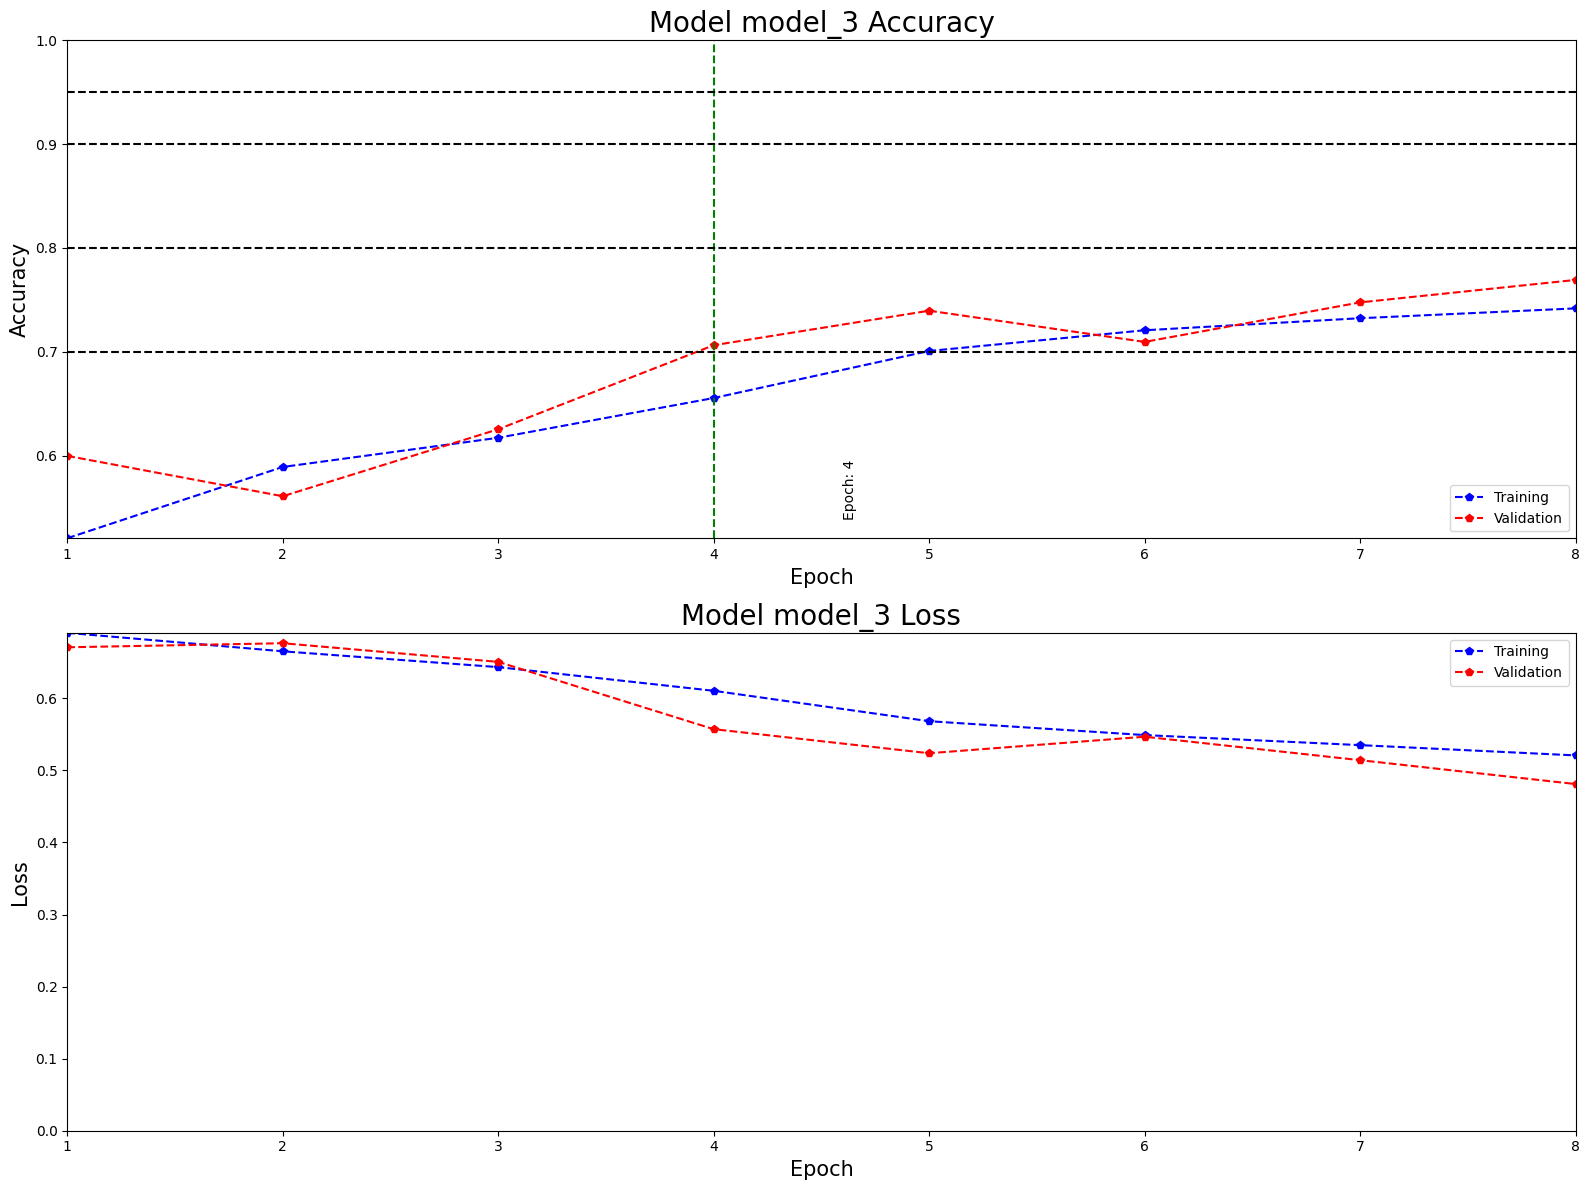

In [ ]:
plot_individual_model_histories(["model_3"])

**#22 New Model 1**

In [ ]:
# New model with additional convolutional layers
new_model_1 = Sequential()

# Block 1
new_model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
new_model_1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
new_model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
new_model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
new_model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Block 5 (NEW ADDED BLOCK)
new_model_1.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Dense layers
new_model_1.add(Flatten())
new_model_1.add(Dropout(0.5))
new_model_1.add(Dense(256, activation='relu'))
new_model_1.add(Dropout(0.5))
new_model_1.add(Dense(128, activation='relu'))
new_model_1.add(Dense(units=1, activation='sigmoid'))

# Model compilation
new_model_1.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

new_model_1.summary()
models.append("new_model_1")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 9, 9, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 2,260,625 (8.62 MB)

 Trainable params: 2,260,625 (8.62 MB)

 Non-trainable params: 0 (0.00 B)

**#23 Training the New Model 1**

In [ ]:
es4 = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history_new_model_1 = new_model_1.fit(train_generator_augmentation,
                                      epochs=8,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[es4])

history_new_model_1_df = pd.DataFrame(history_new_model_1.history)
history_new_model_1_csv_file = 'history/history_new_model_1.csv'

with open(history_new_model_1_csv_file, mode='w') as f:
    history_new_model_1_df.to_csv(f)

Epoch 1/8
256/274 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step - accuracy: 0.5096 - loss: 0.6930

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


274/274 ━━━━━━━━━━━━━━━━━━━━ 134s 465ms/step - accuracy: 0.5104 - loss: 0.6929 - val_accuracy: 0.5056 - val_loss: 0.6847
Epoch 2/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 132s 447ms/step - accuracy: 0.5711 - loss: 0.6772 - val_accuracy: 0.6214 - val_loss: 0.6465
Epoch 3/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 143s 451ms/step - accuracy: 0.6132 - loss: 0.6549 - val_accuracy: 0.6558 - val_loss: 0.6227
Epoch 4/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 124s 453ms/step - accuracy: 0.6341 - loss: 0.6349 - val_accuracy: 0.6719 - val_loss: 0.5926
Epoch 5/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 455ms/step - accuracy: 0.6794 - loss: 0.5930 - val_accuracy: 0.6759 - val_loss: 0.5799
Epoch 6/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 141s 452ms/step - accuracy: 0.7004 - loss: 0.5693 - val_accuracy: 0.7376 - val_loss: 0.5380
Epoch 7/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 520ms/step - accuracy: 0.7200 - loss: 0.5531 - val_accuracy: 0.7448 - val_loss: 0.5170
Epoch 8/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 141s 515ms/step - accuracy: 0.7296 - loss: 0.5402 - va

**#24 Visualization of the New Model 1**

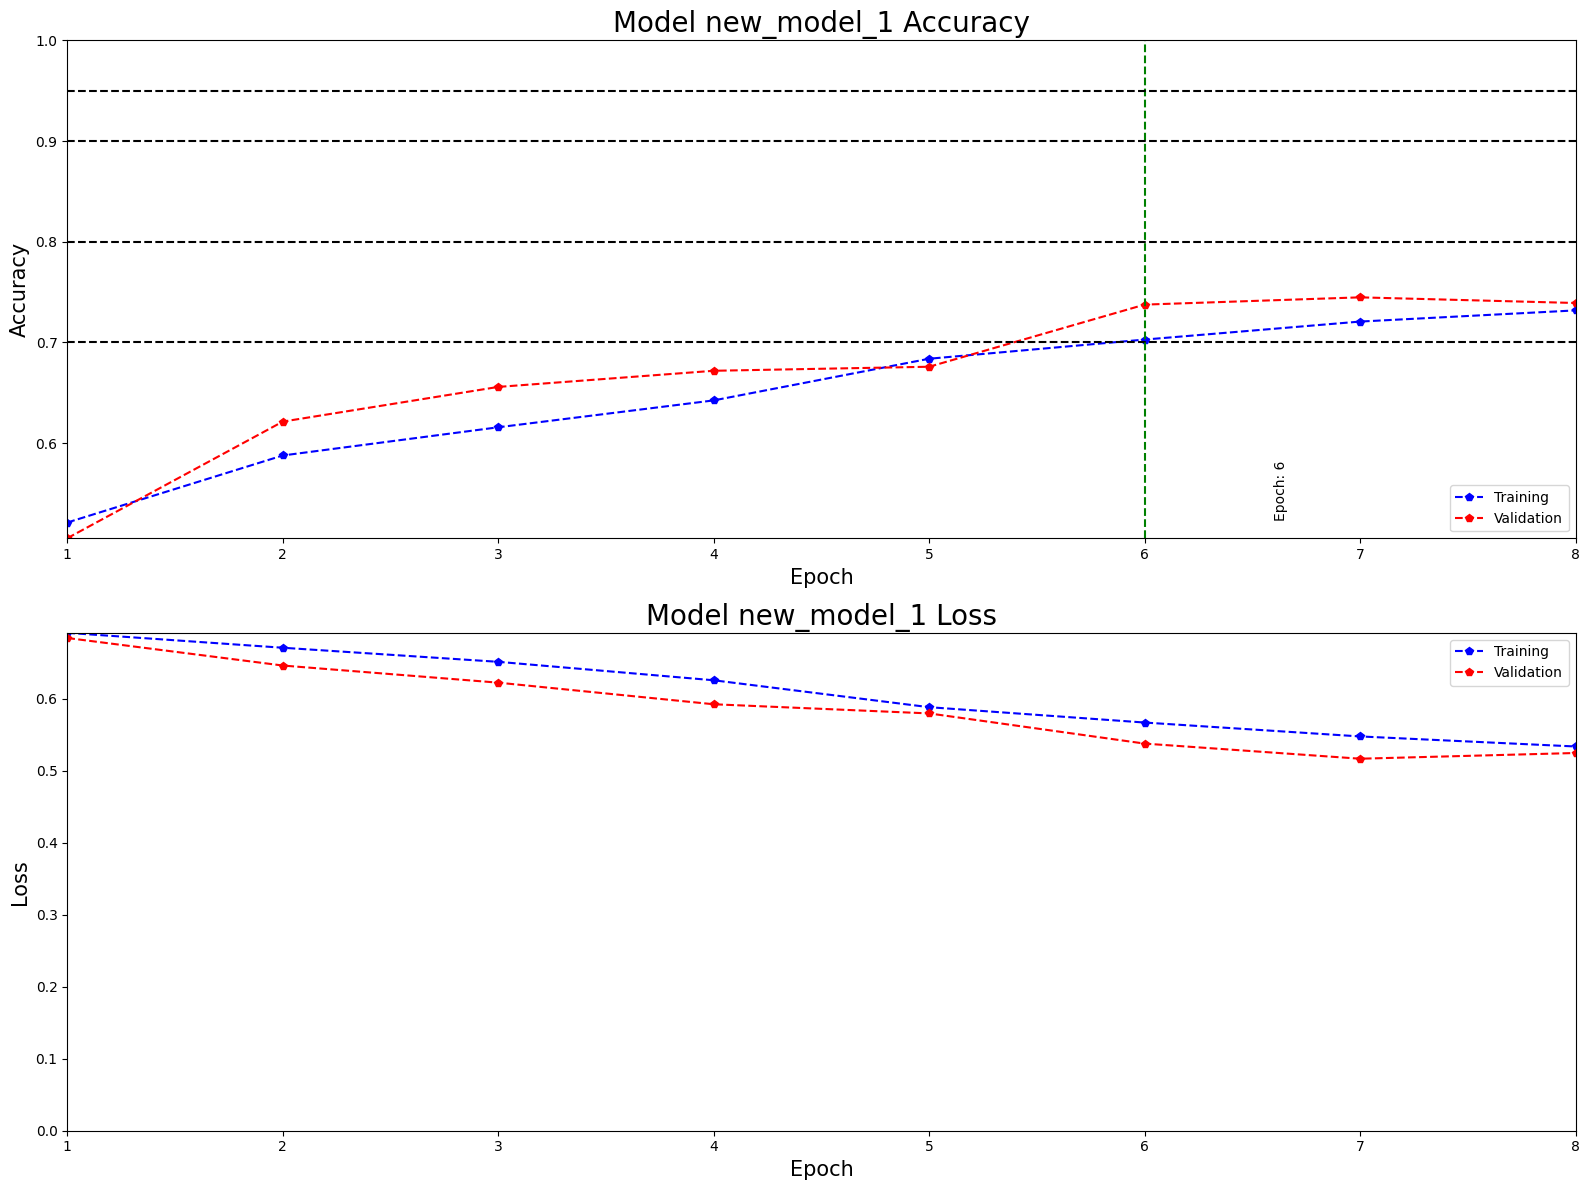

In [ ]:
plot_individual_model_histories(["new_model_1"])

**#25 New Model 2**

In [ ]:
# New model with additional convolutional layers
new_model_2 = Sequential()

# Block 1
new_model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
new_model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))  # New layer
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
new_model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))  # New layer
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
new_model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))  # New layer
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
new_model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))  # New layer
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Block 5
new_model_2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
new_model_2.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))  # New layer
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Dense layers
new_model_2.add(Flatten())
new_model_2.add(Dropout(0.5))
new_model_2.add(Dense(256, activation='relu'))
new_model_2.add(Dropout(0.5))
new_model_2.add(Dense(128, activation='relu'))
new_model_2.add(Dense(units=1, activation='sigmoid'))

# Model compilation
new_model_2.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

new_model_2.summary()
models.append("new_model_2")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 75, 75, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 9, 9, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 9, 9, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,046,785 (11.62 MB)

 Trainable params: 3,046,785 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

**#26 Training the New Model 2**

In [ ]:
es5 = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history_new_model_2 = new_model_2.fit(train_generator_augmentation,
                                      epochs=8,
                                      validation_data=validation_generator,
                                      validation_steps=validation_steps,
                                      callbacks=[es5])

history_new_model_2_df = pd.DataFrame(history_new_model_2.history)
history_new_model_2_csv_file = 'history/history_new_model_2.csv'

with open(history_new_model_2_csv_file, mode='w') as f:
    history_new_model_2_df.to_csv(f)

Epoch 1/8
213/274 ━━━━━━━━━━━━━━━━━━━━ 27s 443ms/step - accuracy: 0.5031 - loss: 0.6932

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


274/274 ━━━━━━━━━━━━━━━━━━━━ 137s 475ms/step - accuracy: 0.5019 - loss: 0.6932 - val_accuracy: 0.4952 - val_loss: 0.6931
Epoch 2/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 126s 460ms/step - accuracy: 0.5035 - loss: 0.6932 - val_accuracy: 0.5645 - val_loss: 0.6930
Epoch 3/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 519ms/step - accuracy: 0.5188 - loss: 0.6928 - val_accuracy: 0.5913 - val_loss: 0.6689
Epoch 4/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 186s 462ms/step - accuracy: 0.5821 - loss: 0.6745 - val_accuracy: 0.6350 - val_loss: 0.6386
Epoch 5/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 518ms/step - accuracy: 0.6059 - loss: 0.6564 - val_accuracy: 0.6386 - val_loss: 0.6290
Epoch 6/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 142s 515ms/step - accuracy: 0.6262 - loss: 0.6411 - val_accuracy: 0.6414 - val_loss: 0.6543
Epoch 7/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 125s 455ms/step - accuracy: 0.6413 - loss: 0.6249 - val_accuracy: 0.6707 - val_loss: 0.5961
Epoch 8/8
274/274 ━━━━━━━━━━━━━━━━━━━━ 143s 520ms/step - accuracy: 0.6604 - loss: 0.6156 - va

**#27 Visualization of the New Model 2**

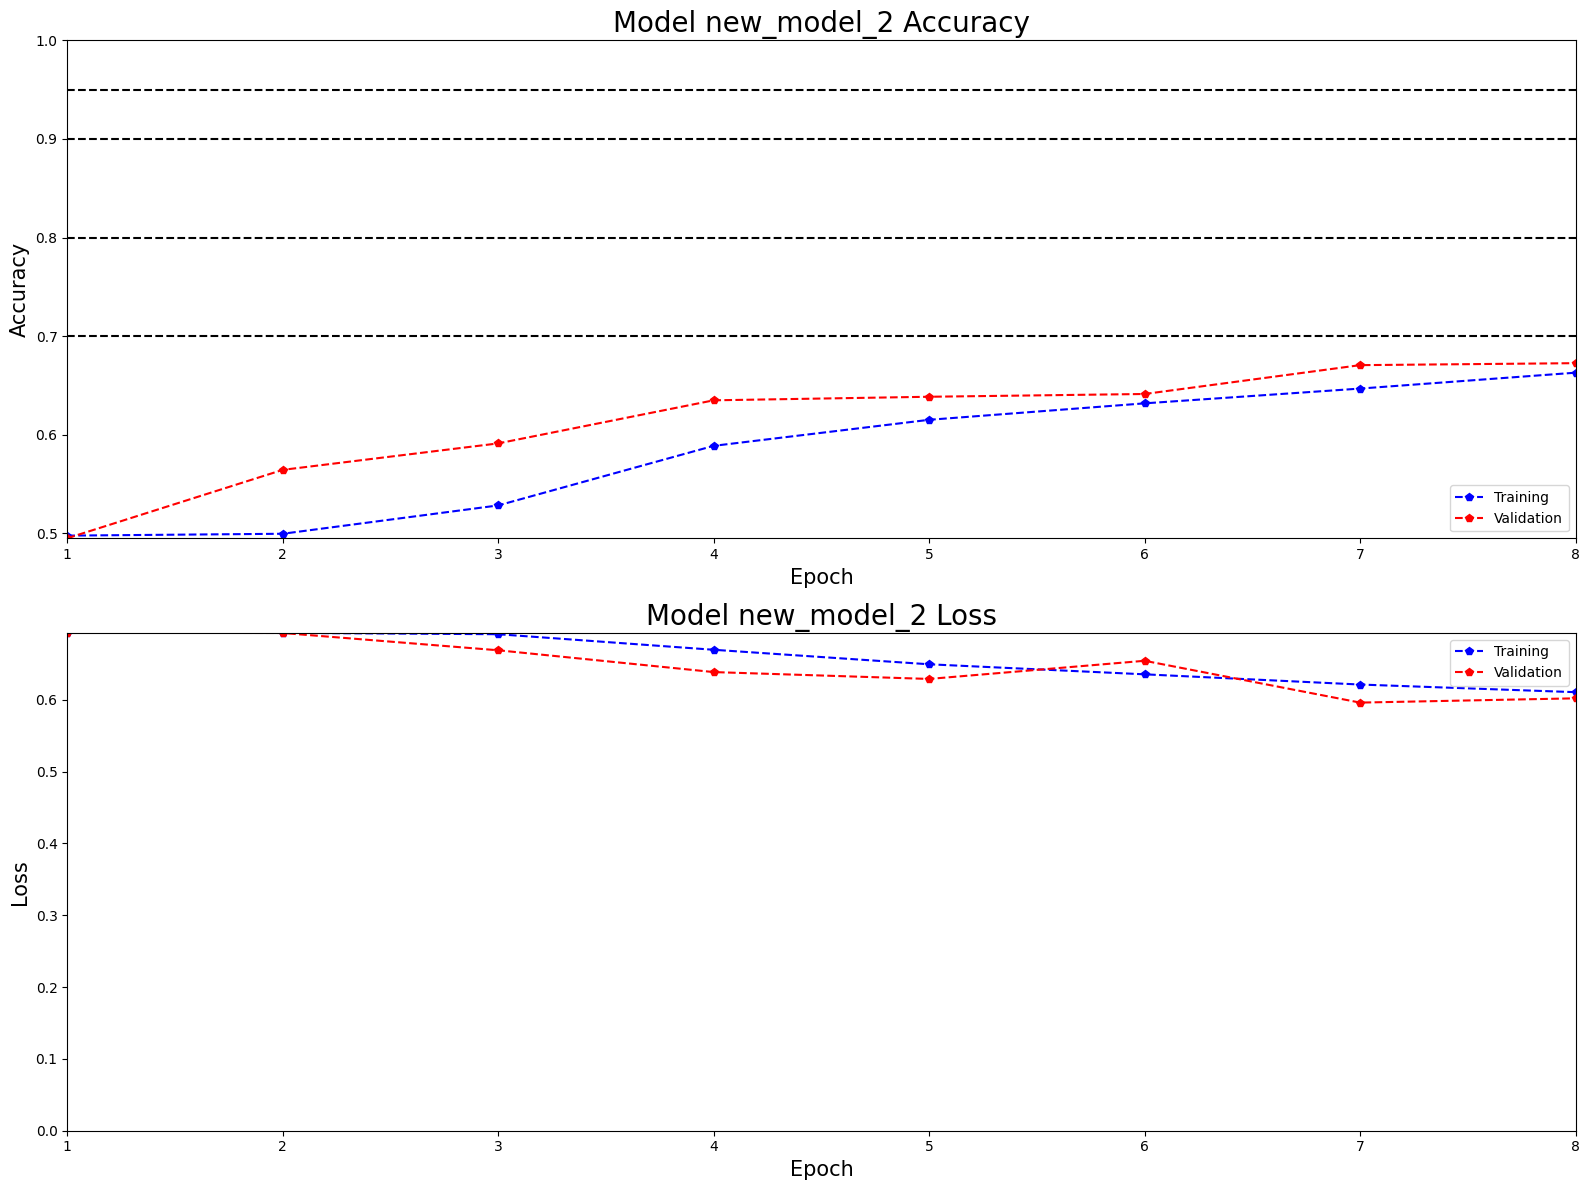

In [ ]:
plot_individual_model_histories(["new_model_2"])

**#28 Visualization of all models**

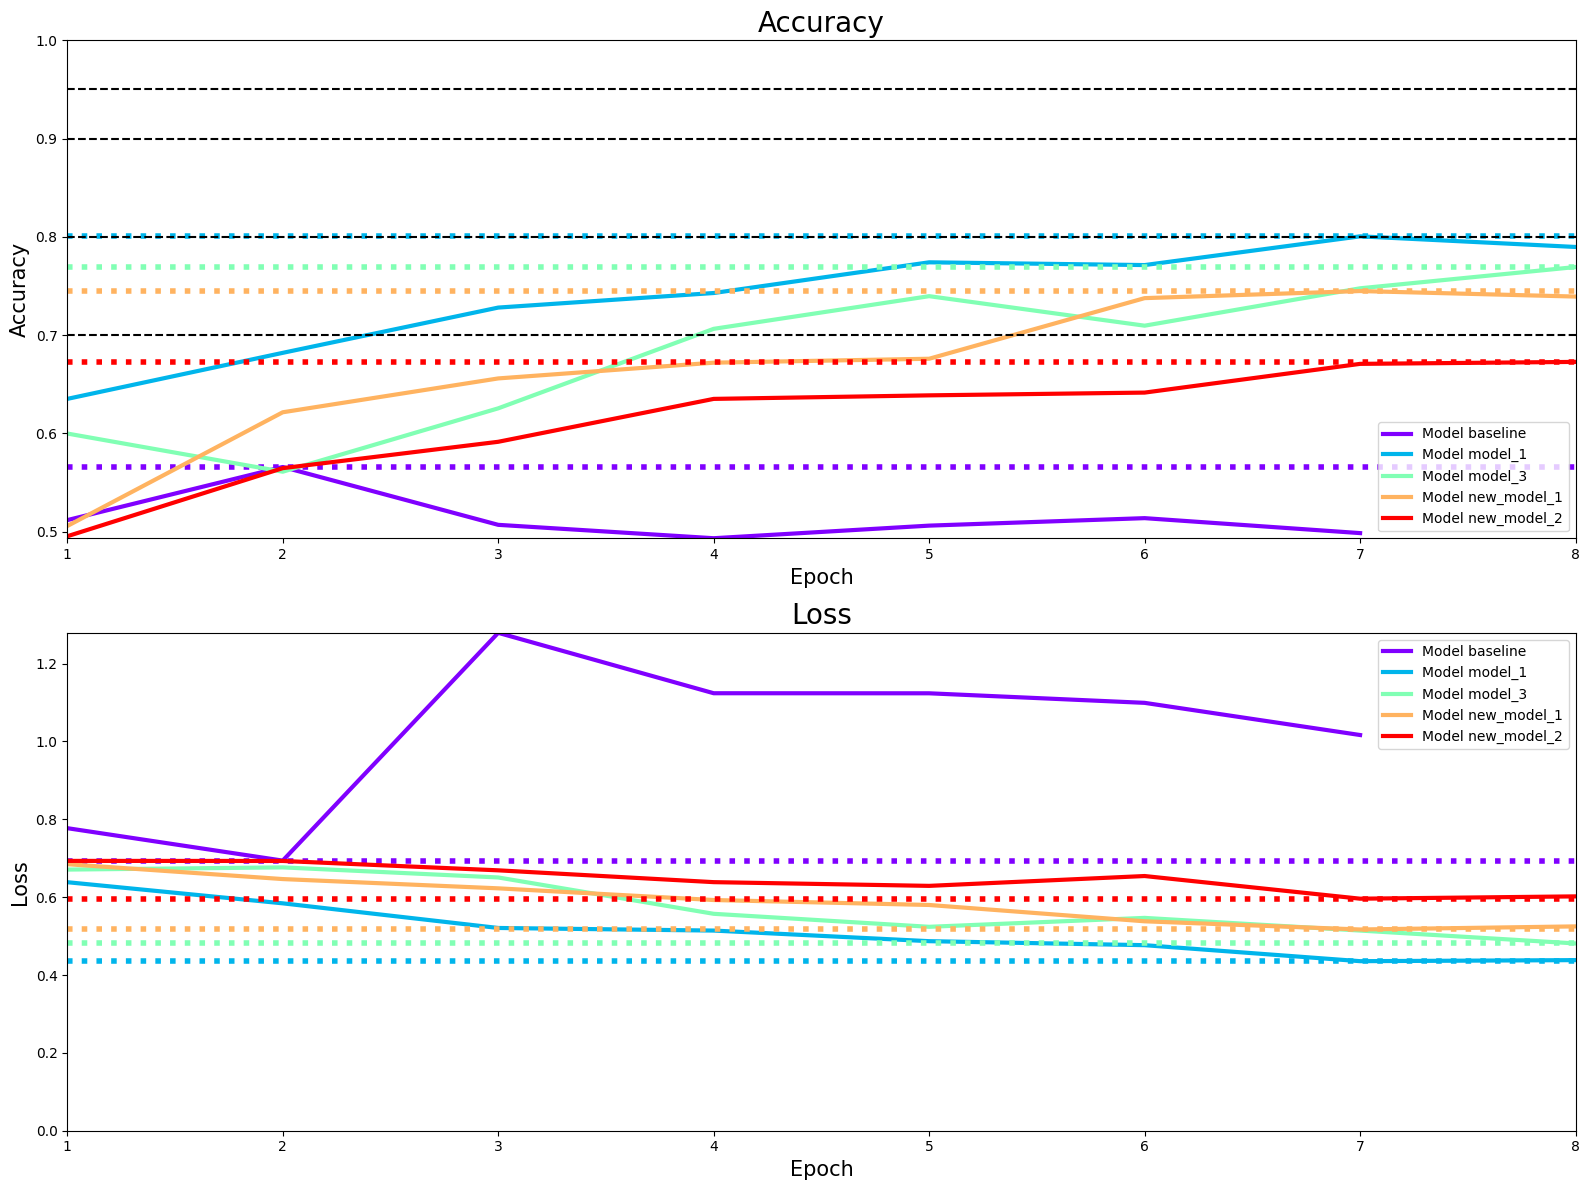

In [ ]:
plot_summary_histories(models)

**#29 Calculation of metrics for all models**

In [ ]:
# Creating a dictionary with models

model_list = {
    "model_baseline": model_baseline,
    "model_1": model_1,
    "model_3": model_3,
    "new_model_1": new_model_1,
    "new_model_2": new_model_2,
}

In [ ]:
# Initialize an empty dictionary to store results
results = {}

# Number of samples in the test set
total_samples = len(test_generator.filenames)

# Calculate the number of steps per epoch
steps_per_epoch = np.ceil(total_samples / test_generator.batch_size).astype(int)

# Calculate metrics
for model_name, model in model_list.items():
    print(f"Evaluating model: {model_name}")

    # Predict results using the data generator
    predictions = model.predict(test_generator, steps=steps_per_epoch)

    # Convert predictions to binary (0 or 1)
    predictions = (predictions > 0.5).astype("int32").flatten()

    # True labels
    true_labels = test_generator.classes

    # Calculate metrics
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    accuracy = accuracy_score(true_labels, predictions)
    roc_auc = roc_auc_score(true_labels, predictions)

    # Display metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"ROC AUC: {roc_auc}")
    print("\n")

    # Store results for each model
    results[model_name] = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "roc_auc": roc_auc
    }

Evaluating model: model_baseline


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step
Precision: 0.482484076433121
Recall: 0.2424
F1 Score: 0.3226837060702875
Accuracy: 0.4912
ROC AUC: 0.49119999999999997


Evaluating model: model_1
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step
Precision: 0.5119225037257824
Recall: 0.5496
F1 Score: 0.5300925925925926
Accuracy: 0.5128
ROC AUC: 0.5127999999999999


Evaluating model: model_3
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step
Precision: 0.5097517730496454
Recall: 0.46
F1 Score: 0.48359966358284273
Accuracy: 0.5088
ROC AUC: 0.5087999999999999


Evaluating model: new_model_1
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step
Precision: 0.49765258215962443
Recall: 0.5936
F1 Score: 0.5414082451659978
Accuracy: 0.4972
ROC AUC: 0.4972


Evaluating model: new_model_2
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step
Precision: 0.5029051000645578
Recall: 0.6232
F1 Score: 0.556627366916756
Accuracy: 0.5036
ROC AUC: 0.5036




**#30 Summary**

The **baseline model** achieved the **poorest results**, with very low **precision** (0.48), **recall** (0.24), and **F1-score** (0.32). Its **accuracy** (49.12%) and **ROC AUC** (49.12%) suggest it performs at the level of a **random classifier**.

**Model 1** performed slightly better, with **precision** of 0.51 and **recall** of 0.55, leading to an **F1-score** of 0.53. Its **accuracy** was 51.28%, indicating a **slight improvement** over the baseline model. A **similar result** was achieved by **Model 3**, though its **recall** was lower (0.46), which led to a slightly worse **F1-score** (0.48). Its **accuracy** was 50.88%, showing only a **minimal improvement**.

The new version of the model, **new_model_1**, exhibited higher **recall** (0.59) but at the cost of lower **precision** (0.49). As a result, its **F1-score** reached 0.54, a **better result than Model 3**. However, its **accuracy** was 49.72%, still close to the level of a **random classifier**.

The best performance was achieved by **new_model_2**, which attained the highest **recall** (0.62) and **F1-score** (0.55). Its **accuracy** was 50.36%, indicating a **slight but noticeable improvement**.

**In summary:**

On the comparison chart of all models, we can see that the **accuracy** of the models increases and the **loss** decreases with each epoch.

However, using **8 epochs** allows for testing the functionality of the code, but not for meaningful comparison of the models. Unfortunately, due to **limitations of the Colab service**, this is the only way to execute the entire code at once.

Using **more epochs** along with **early stopping** would allow for a better comparison of the models' performance.